In [0]:
import os
import numpy as np
import tensorflow as tf
import time
import math
import pandas as pd
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_olivetti_faces
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

# !pip install pyyaml h5py  # Required to save models in HDF5 format



In [2]:
# Mount directories
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# import my utility functions
import sys
sys.path.append('/content/gdrive/My Drive/CSCI1430_Final_Project/')
from utils import *

In [0]:
# Load training and testing data
path = '/content/gdrive/My Drive/CSCI1430_Final_Project/Data/Kaggle/'
train_data = pd.read_csv(path+'training.csv')
train_data.fillna(method='ffill',inplace=True)

In [0]:
# Get images
training_images = []
for i in range(0,len(train_data)):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    training_images.append(img)
training_images = np.asarray(training_images, dtype = 'float')
    

In [6]:
# Get labels
del train_data['Image']
labels = train_data.values
labels.shape

(7049, 30)

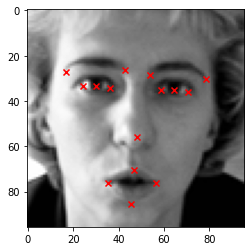

In [7]:
# Show sample image
plt.imshow(training_images[1].reshape(96,96),cmap='gray')
plt.scatter(labels[1][0::2], labels[1][1::2], c='red', marker='x')


In [0]:
# Split data for training facial landmarks classifier
X_train, X_test, y_train, y_test = train_test_split(training_images.reshape(-1, 96, 96, 1), labels, random_state=43, test_size=0.33)

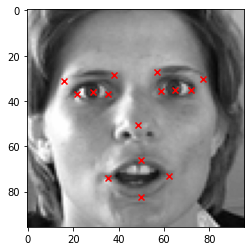

In [9]:
# Make sure everything lines up still
plt.imshow(X_train[0].reshape(96,96),cmap='gray')

plt.scatter(y_train[0][0::2], y_train[0][1::2], c='red', marker='x')


In [0]:
# Now let's create our keras model

# This architecture gets .6055 accuracy on landmarks
# def create_model():
#   model = keras.models.Sequential()
#   model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
#   model.add(keras.layers.MaxPooling2D((2, 2)))
#   model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(keras.layers.MaxPooling2D((2, 2)))
#   model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(keras.layers.MaxPooling2D((2, 2)))
#   model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
#   model.add(keras.layers.MaxPooling2D((2, 2)))
#   model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(keras.layers.Flatten())
#   model.add(keras.layers.Dense(64, activation='relu'))
#   model.add(keras.layers.Dense(units=30, activation='relu'))
#   model.compile(optimizer='adam',
#               loss='mse',
#               metrics=['accuracy'])
#   return model

# Adding in batch normalization
# 0.8483 accuracy on landmarks, ~65% accuracy for FR
def create_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(units=30, activation='relu'))
  model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
  return model







In [0]:
# FOR TRAINING MODEL
# Create a basic model instance
model = create_model()
# Display the model's architecture
model.summary()
# Save checkpoints during training
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Fit model
model.fit(X_train, y_train, epochs=100, callbacks=[cp_callback])




In [0]:
model.save('/content/gdrive/My Drive/CSCI1430_Final_Project/facial_landmarks_model/model.h5')

In [10]:
# Load from checkpoint
# # Create a new model instance
# model = create_model()
# # Load the previously saved weights
# checkpoint_path = "training_2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)


# Load from saved model format
model = tf.keras.models.load_model('/content/gdrive/My Drive/CSCI1430_Final_Project/facial_landmarks_model/model.h5')

loss, acc = model.evaluate(X_train, y_train, verbose=2)


148/148 - 73s - loss: 211.5253 - accuracy: 0.8590


In [11]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


73/73 - 33s - loss: 210.9757 - accuracy: 0.8483


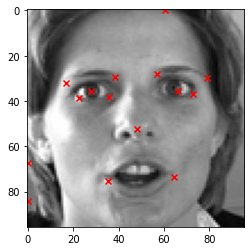

In [12]:
# Show me an example prediction on the training set
plt.imshow(X_train[0].reshape(96,96),cmap='gray')

predictions = model.predict(X_train[0].reshape(-1, 96, 96, 1))
plt.scatter(np.squeeze(predictions)[0::2], np.squeeze(predictions)[1::2], c='red', marker='x')

## Now let's do facial recognition 

In [0]:
# Get olivetti images for face recognition

olivetti = fetch_olivetti_faces()
olivetti_faces = olivetti.images
id_labels = olivetti.target




resized images


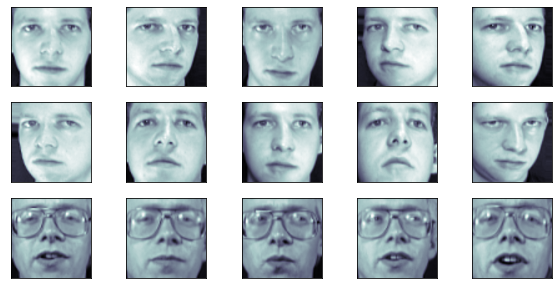

In [14]:
# Reshape olivetti faces because model was trained on 96,96 images and olivetti are 64,64
resized_olive = np.zeros((olivetti_faces.shape[0], 96, 96))

for i in range(len(resized_olive)):
  resized_olive[i] = cv2.resize(olivetti_faces[i], (96, 96))


show_images_in_dataset(resized_olive)
print("resized images")

In [0]:
# Predict landmarks
olive_landmarks = model.predict(resized_olive.reshape(-1, 96, 96, 1))

Predicted landmarks on an Olivetti person across 5 of their images


<Figure size 7200x7200 with 0 Axes>

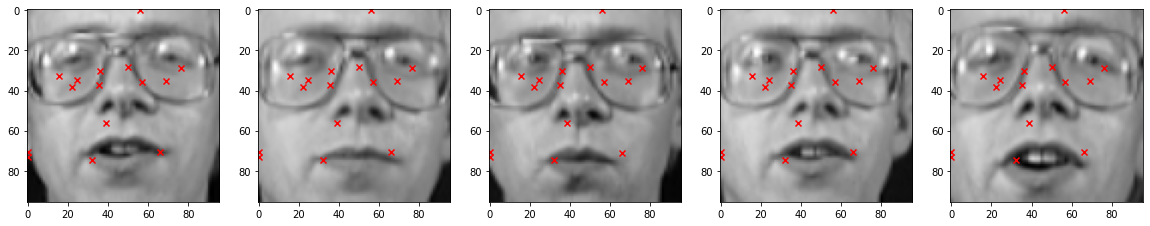

In [16]:
#Show example prediction on same person in two different images

print("Predicted landmarks on an Olivetti person across 5 of their images")

plt.figure(figsize=(100,100))
f, axarr = plt.subplots(1,5, figsize=(20, 30)) 
for i in range(0, 5):
  axarr[i].imshow(resized_olive[i+10].reshape(96,96),cmap='gray')
  axarr[i].scatter(olive_landmarks[i+10][0::2], olive_landmarks[i+10][1::2], c='red', marker='x')


In [0]:
# number of images per person to train on 
percent_train_list = [1,2,3,4,5,6,7,8,9]

accuracy_mat = np.zeros((len(percent_train_list)+1))

for r in range(10):

  for train_amount in percent_train_list:
    X_train, X_test, y_train, y_test = train_test_split(olive_landmarks \
    , id_labels, test_size=(1-train_amount/10), random_state=r, stratify=id_labels)

    # Just use closest based on euclidean distance
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    # print("Accuracy at predicting identification of {} faces in test set is: {}".format(len(testY), acc))
    accuracy_mat[train_amount] += acc

accuracy_mat = accuracy_mat/10

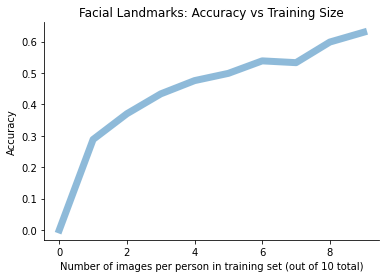

In [18]:
plt.plot(accuracy_mat, alpha=0.5, lw=7)
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Facial Landmarks: Accuracy vs Training Size')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [19]:
print("Highest accuracy achieved: ", np.max(accuracy_mat))

Highest accuracy achieved:  0.63


In [20]:
print("Accuracies at increasing number of training images:")
print(accuracy_mat)

Accuracies at increasing number of training images:
[0.         0.28833333 0.3703125  0.43357143 0.47583333 0.499
 0.53875    0.53305785 0.59875    0.63      ]


MLP TO PREDICT

In [21]:
# one hot encode labels
from keras.utils import to_categorical
one_hot_labels = to_categorical(id_labels, num_classes=40)
print(one_hot_labels)

# # invert encoding
# inverted = argmax(encoded[0])
# print(inverted)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Using TensorFlow backend.


In [0]:
# train test split
train_amount = 7
X_train, X_test, y_train, y_test = train_test_split(olive_landmarks \
  , one_hot_labels, test_size=(1-train_amount/10), random_state=100, stratify=one_hot_labels)

In [0]:

mlp = keras.Sequential()
mlp.add(keras.layers.Dense(512, activation='relu', input_shape=(30,)))
mlp.add(keras.layers.Dropout(0.2))
mlp.add(keras.layers.Dense(512, activation='relu'))
mlp.add(keras.layers.Dense(256, activation='relu'))
mlp.add(keras.layers.Dense(128, activation='relu'))
mlp.add(keras.layers.Dropout(0.2))
mlp.add(keras.layers.Dense(40, activation='softmax'))
# mlp.summary()
mlp.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [24]:
history = mlp.fit(X_train, y_train,
                    epochs=100, verbose=1, validation_data=(X_test, y_test))
score = mlp.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
9/9 [==============================] - 0s 24ms/step - loss: 10.9777 - accuracy: 0.0000e+00 - val_loss: 3.9267 - val_accuracy: 0.0248
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 4.0475 - accuracy: 0.0215 - val_loss: 3.7054 - val_accuracy: 0.0248
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 3.8225 - accuracy: 0.0143 - val_loss: 3.7163 - val_accuracy: 0.0248
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 3.7757 - accuracy: 0.0215 - val_loss: 3.7185 - val_accuracy: 0.0248
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 3.7516 - accuracy: 0.0287 - val_loss: 3.8835 - val_accuracy: 0.0331
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 3.8001 - accuracy: 0.0287 - val_loss: 3.7778 - val_accuracy: 0.0248
Epoch 7/100
9/9 [==============================] - 0s 13ms/step - loss: 3.7367 - accuracy: 0.0108 - val_loss: 3.6890 - val_accuracy: 0.0248
Epoch 8/100
9/9